# Imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import os
import numpy as np

import json

from transformers import MarianTokenizer
import numpy as np
import matplotlib.pyplot as plt
import collections
from collections import defaultdict

In [24]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
src_lang = "en"
translator = "opus-mt"

# Defining plot styles

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kde, gaussian_kde
import matplotlib
from matplotlib import rc

import pandas as pd

In [4]:


plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


# Load / Process Data

In [5]:
RECALL=-3
PRECISION=-1

TRANSLATOR="opus-mt"
SRC_LANG="en"

In [6]:
def load_old_tokens_dict(tokens_file):
    with open(tokens_file, "r") as f:
        tokens_str = (f.readlines())[0]
    tokens_str = tokens_str.replace("'", "\"")
    tokens_dict = json.loads(tokens_str)
    
    if 'worker' in tokens_dict:
        tokens_dict.pop('worker')
        
    return tokens_dict


def create_tokens_dict(variants_file, translator, src_lang, tgt_lang):
    tokens_dict = defaultdict(dict)
    tokenizer = MarianTokenizer.from_pretrained(f"Helsinki-NLP/{translator}-{src_lang}-{tgt_lang}")
    
    with open(variants_file, 'r') as var_json:
        variants_dict = json.load(var_json)
    
    for prof_gender, variants in variants_dict.items():
        prof, gender = prof_gender.split('-')
        gender = gender.capitalize()
        for v_idx, var in enumerate(variants):
            with tokenizer.as_target_tokenizer():
                tokenized = tokenizer(var)
                num_tokens = len(tokenized['input_ids']) - 1
            
            tokens_dict[f"{prof}-{str(v_idx)}"][gender] = num_tokens
    return tokens_dict


In [13]:
tokens_dict_he = create_tokens_dict("../data/wino_mt/he_variants.json",TRANSLATOR, SRC_LANG, "he")
tokens_dict_de = create_tokens_dict("../data/wino_mt/de_variants.json",TRANSLATOR, SRC_LANG, "de")

In [45]:
tokens_dict_es = create_tokens_dict("../data/wino_mt/es_variants.json",TRANSLATOR, SRC_LANG, "es")

In [9]:
with open("../data/male_stereotype","r") as f:
    male_stereotype = f.readlines()
    male_stereotype = {i.strip().lower() for i in male_stereotype}

In [10]:
male_stereotype

{'analyst',
 'carpenter',
 'ceo',
 'chief',
 'construction worker',
 'cook',
 'developer',
 'driver',
 'farmer',
 'guard',
 'janitor',
 'laborer',
 'lawyer',
 'manager',
 'mechanic',
 'mover',
 'physician',
 'salesperson',
 'sheriff',
 'supervisor'}

# Create Plots

In [44]:
def graph_5_delta_g(results_file,tokens_dict,lang):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()

    
    for p in professions:
        delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))


    x = []
    y = []
    
    data = pd.DataFrame({"$\Delta T$": [], "$\Delta G$": [], "M F1": [], "F F1": [], "M T": [], "F T": []})
    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
                
            data = data.append({"$\Delta T$": delta_t, "$\Delta G$": male_f1 - female_f1,
                                "M F1": male_f1, "F F1": female_f1,
                                "M T": tokens_dict[prof]['Male'], "F T": tokens_dict[prof]['Female']},
                               ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="$\Delta T$", y="$\Delta G$",
        orient="v",
        notch=False, showcaps=False, showmeans=False,
        boxprops={"facecolor": (.4, .6, .8, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="$\Delta T$", y="$\Delta G$", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{21}_delta_g.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())
    
    tidy = data.melt(value_vars=['M F1','F F1'], id_vars=['M T'], value_name='F1',var_name='gender')
    print(tidy)
    
    sns.catplot(x="M T", y='F1',
        data=tidy, kind="bar", hue='gender', 
        palette=sns.color_palette(['lightblue', 'brown']),
        height=4.5, aspect=1.8)


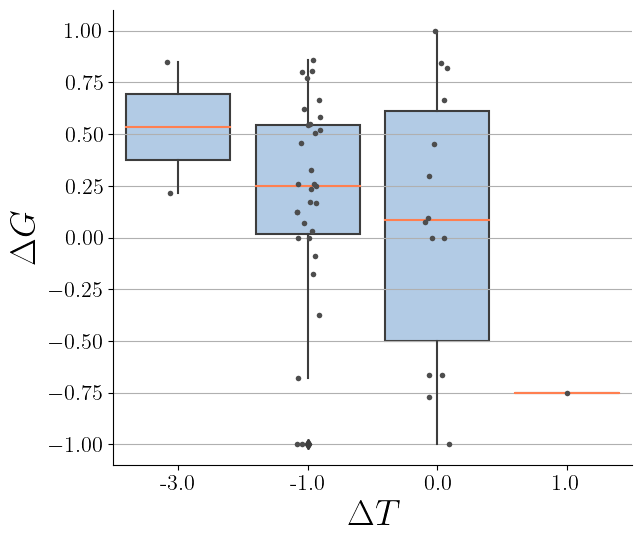

correlation
            $\Delta T$  $\Delta G$      M F1      F F1       M T       F T
$\Delta T$    1.000000   -0.249129 -0.244322  0.161575  0.307190 -0.554959
$\Delta G$   -0.249129    1.000000  0.773641 -0.830557 -0.315953 -0.071033
M F1         -0.244322    0.773641  1.000000 -0.289667 -0.500019 -0.235892
F F1          0.161575   -0.830557 -0.289667  1.000000  0.037767 -0.100042
M T           0.307190   -0.315953 -0.500019  0.037767  1.000000  0.621176
F T          -0.554959   -0.071033 -0.235892 -0.100042  0.621176  1.000000
    M T gender        F1
0   1.0   M F1  0.850000
1   1.0   M F1  0.761905
2   1.0   M F1  0.776471
3   1.0   M F1  0.678261
4   1.0   M F1  0.933333
..  ...    ...       ...
91  1.0   F F1  1.000000
92  2.0   F F1  0.800000
93  2.0   F F1  0.440000
94  2.0   F F1  0.000000
95  2.0   F F1  0.750000

[96 rows x 3 columns]


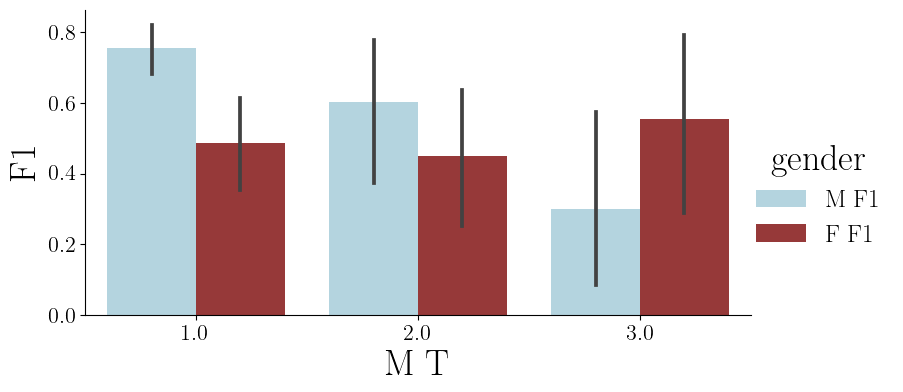

In [46]:
graph_5_delta_g("../data/de_results.txt", tokens_dict_de,"German")

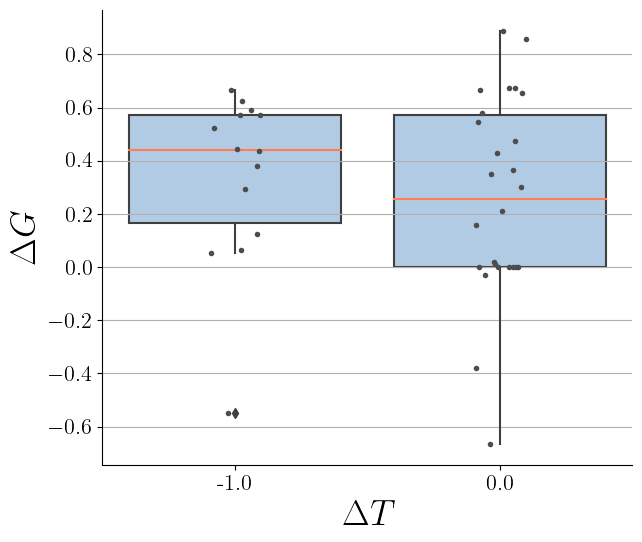

correlation
            $\Delta T$  $\Delta G$      M F1      F F1       M T       F T
$\Delta T$    1.000000   -0.109746  0.213144  0.229803  0.060523 -0.721798
$\Delta G$   -0.109746    1.000000  0.266439 -0.835765  0.077051  0.137245
M F1          0.213144    0.266439  1.000000  0.306559 -0.074438 -0.214405
F F1          0.229803   -0.835765  0.306559  1.000000 -0.118498 -0.257679
M T           0.060523    0.077051 -0.074438 -0.118498  1.000000  0.647150
F T          -0.721798    0.137245 -0.214405 -0.257679  0.647150  1.000000
    M T gender        F1
0   1.0   M F1  0.714286
1   1.0   M F1  0.693333
2   1.0   M F1  0.521739
3   1.0   M F1  0.794118
4   1.0   M F1  0.695652
..  ...    ...       ...
75  1.0   F F1  0.714286
76  2.0   F F1  0.000000
77  2.0   F F1  0.230769
78  1.0   F F1  0.545455
79  2.0   F F1  0.000000

[80 rows x 3 columns]


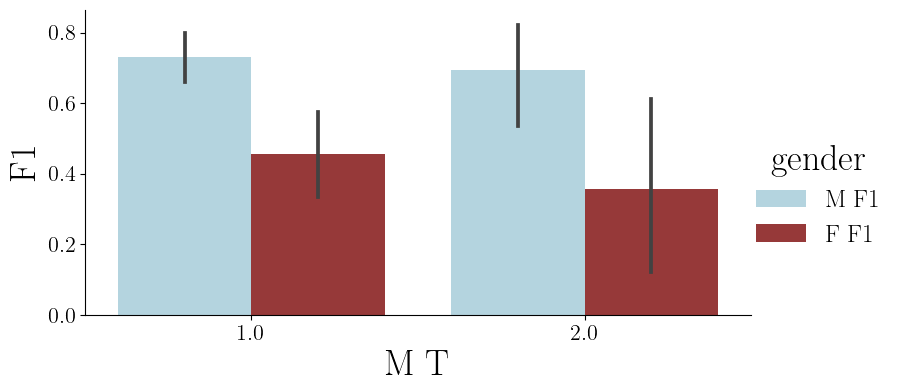

In [47]:
graph_5_delta_g("../data/he_results.txt", tokens_dict_he,"Hebrew")

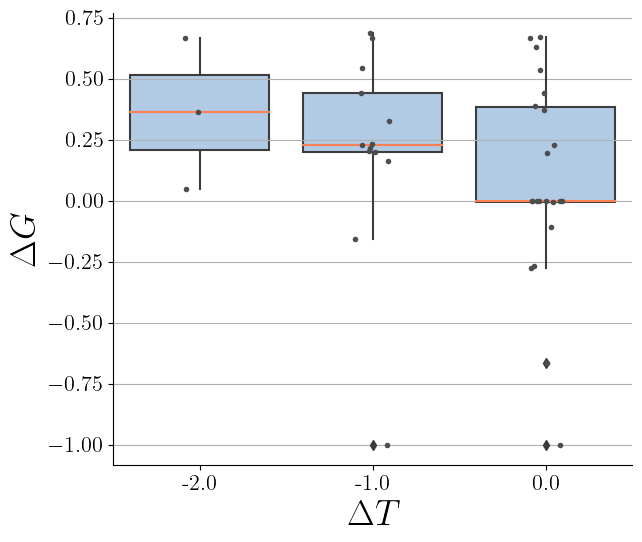

correlation
            $\Delta T$  $\Delta G$      M F1      F F1       M T       F T
$\Delta T$    1.000000   -0.211679  0.064710  0.291136  0.297607 -0.547713
$\Delta G$   -0.211679    1.000000  0.515530 -0.798832 -0.332977 -0.120665
M F1          0.064710    0.515530  1.000000  0.103634 -0.258520 -0.278881
F F1          0.291136   -0.798832  0.103634  1.000000  0.205014 -0.055722
M T           0.297607   -0.332977 -0.258520  0.205014  1.000000  0.635753
F T          -0.547713   -0.120665 -0.278881 -0.055722  0.635753  1.000000
    M T gender        F1
0   1.0   M F1  0.717949
1   1.0   M F1  0.666667
2   1.0   M F1  0.869565
3   1.0   M F1  0.727273
4   1.0   M F1  0.769231
..  ...    ...       ...
71  1.0   F F1  0.816327
72  1.0   F F1  0.313725
73  1.0   F F1  1.000000
74  3.0   F F1  1.000000
75  2.0   F F1  1.000000

[76 rows x 3 columns]


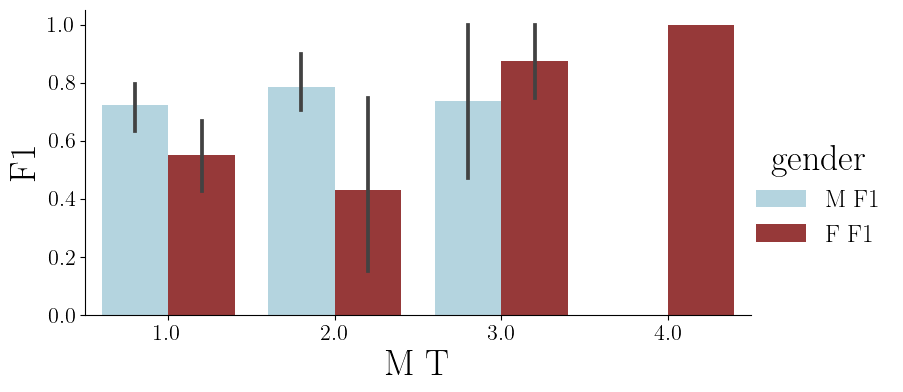

In [48]:
graph_5_delta_g("../data/es_results.txt", tokens_dict_es,"Spanish")

In [53]:
def graph_5_delta_s(results_file,tokens_dict,lang, male_stereotype):
    with open(results_file, "r") as f:
        lines = f.readlines()
        recalls_str = lines[RECALL]
        recalls_str = recalls_str.replace("'", "\"")
        recalls_dict = json.loads(recalls_str)

        precisions_str = lines[PRECISION]
        precisions_str = precisions_str.replace("'", "\"")
        precisions_dict = json.loads(precisions_str)

    professions = list(tokens_dict.keys())
    delta_t_dict = dict()
    
    for p in professions:
        if p.split('-')[0] in male_stereotype:
            delta_t_dict[p] = tokens_dict[p]['Male'] - tokens_dict[p]['Female']
        else:
            delta_t_dict[p] = tokens_dict[p]['Female'] - tokens_dict[p]['Male']
    delta_t_dict = dict(sorted(delta_t_dict.items(), key=lambda item: item[1]))



    data = pd.DataFrame({"$\Delta T$": [], "$\Delta S$": [], "P F1": [], "A F1": [], "P T": [], "A T": []})

    for prof, delta_t in delta_t_dict.items():
        prof = prof.lower()
        if prof in recalls_dict and prof in precisions_dict:
            r_m,r_f=recalls_dict[prof]['male_recall'],recalls_dict[prof]['female_recall']
            p_m,p_f=precisions_dict[prof]['male_precision'],precisions_dict[prof]['female_precision']
            if r_m ==0 and p_m == 0:
                male_f1 = 0
            else:
                male_f1= 2 * (r_m*p_m)/(r_m+p_m)
    
            if r_f ==0 and p_f == 0:
                female_f1 = 0
            else:
                female_f1= 2 * (r_f*p_f)/(r_f+p_f)
            
            if prof.split('-')[0] in male_stereotype:
                # data = data.append({"Delta T": delta_t, "Delta S": male_f1 - female_f1}, ignore_index=True)
                data = data.append({"$\Delta T$": delta_t, "$\Delta S$": male_f1 - female_f1,
                    "P F1": male_f1, "A F1": female_f1,
                    "P T": tokens_dict[prof]['Male'], "A T": tokens_dict[prof]['Female']},
                   ignore_index=True)
            else:
                # data = data.append({"Delta T": delta_t, "Delta S": female_f1 - male_f1}, ignore_index=True)
                data = data.append({"$\Delta T$": delta_t, "$\Delta S$": female_f1 - male_f1,
                    "P F1": female_f1, "A F1": male_f1,
                    "P T": tokens_dict[prof]['Female'], "A T": tokens_dict[prof]['Male']},
                   ignore_index=True)


    f, ax = plt.subplots(figsize=(7, 6))

    sns.boxplot(
        data=data, x="$\Delta T$", y="$\Delta S$",
        orient="v",
        notch=False, showcaps=False,showmeans=False,
        boxprops={"facecolor": (.6, .8, .4, .5)},
        medianprops={"color": "coral"})
    sns.stripplot(x="$\Delta T$", y="$\Delta S$", data=data,
              size=4, color=".3", linewidth=0)
    
#     z = np.polyfit(data['Delta T'], data['Delta G'], 1)
#     p = np.poly1d(z)
#     ax.plot(data['Delta T'] + len(data['Delta T'].unique())- 1, p(data['Delta T']), "r--")

    # Tweak the visual presentation
    ax.yaxis.grid(True)
    sns.despine(trim=False)
    
    plt.tight_layout()
    plt.savefig(f'../graphs/graph_5_{lang}_delta_s.pdf')
    plt.show()
    
    print("correlation")
    print(data.corr())
    
    tidy = data.melt(value_vars=['P F1','A F1'], id_vars=['P T'], value_name='F1',var_name='stereotpe')
    print(tidy)
    
    sns.catplot(x="P T", y='F1',
        data=tidy, kind="bar", hue='stereotpe', 
        palette=sns.color_palette(['mediumaquamarine', 'darkorange']),
        height=4.5, aspect=1.8)


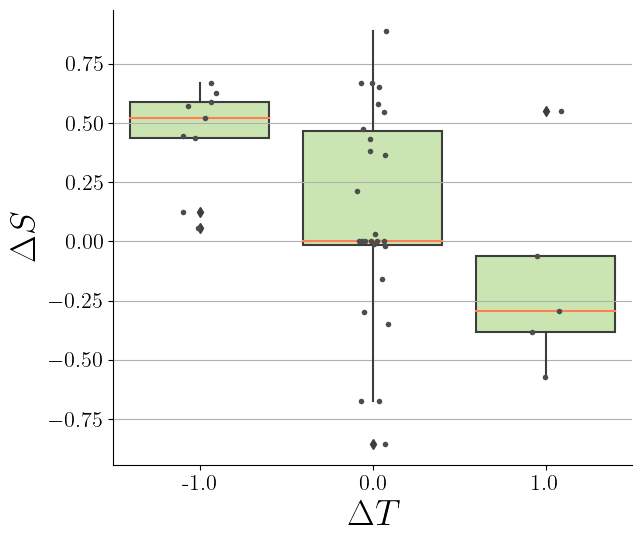

correlation
            $\Delta T$  $\Delta S$      P F1      A F1       P T       A T
$\Delta T$    1.000000   -0.414946 -0.268046  0.297326  0.556090 -0.477994
$\Delta S$   -0.414946    1.000000  0.567724 -0.776445 -0.113728  0.322013
P F1         -0.268046    0.567724  1.000000  0.077973 -0.234556  0.037766
A F1          0.297326   -0.776445  0.077973  1.000000 -0.041826 -0.361062
P T           0.556090   -0.113728 -0.234556 -0.041826  1.000000  0.464219
A T          -0.477994    0.322013  0.037766 -0.361062  0.464219  1.000000
    P T stereotpe        F1
0   1.0      P F1  0.693333
1   1.0      P F1  0.521739
2   1.0      P F1  0.794118
3   1.0      P F1  0.866667
4   1.0      P F1  0.676923
..  ...       ...       ...
75  2.0      A F1  0.714286
76  2.0      A F1  0.695652
77  3.0      A F1  0.571429
78  2.0      A F1  0.736842
79  3.0      A F1  0.133333

[80 rows x 3 columns]


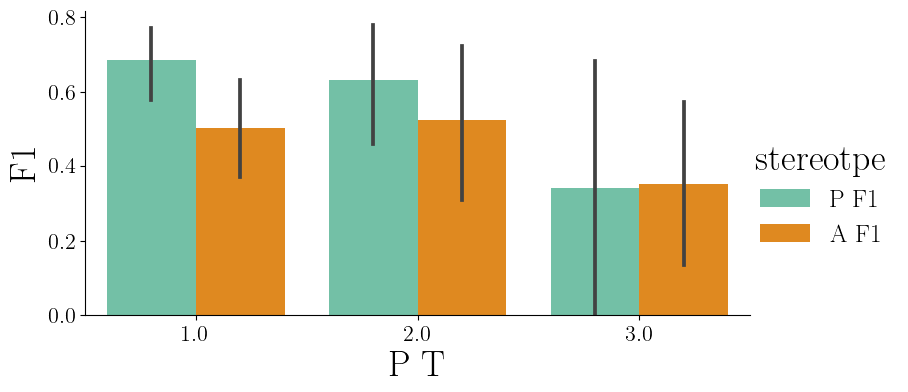

In [54]:
graph_5_delta_s("../data/he_results.txt", tokens_dict_he,"Hebrew", male_stereotype)

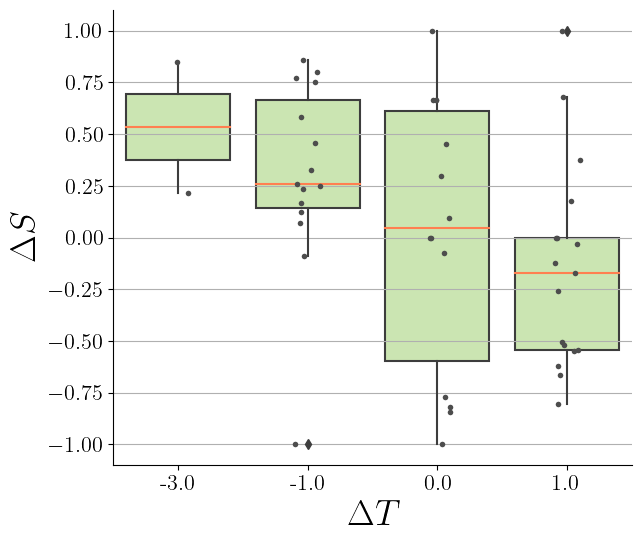

correlation
            $\Delta T$  $\Delta S$      P F1      A F1       P T       A T
$\Delta T$    1.000000   -0.368684 -0.296008  0.303112  0.622846 -0.540084
$\Delta S$   -0.368684    1.000000  0.798157 -0.826557 -0.172690  0.260378
P F1         -0.296008    0.798157  1.000000 -0.320632 -0.301795  0.033546
A F1          0.303112   -0.826557 -0.320632  1.000000 -0.010448 -0.378039
P T           0.622846   -0.172690 -0.301795 -0.010448  1.000000  0.322041
A T          -0.540084    0.260378  0.033546 -0.378039  0.322041  1.000000
    P T stereotpe        F1
0   1.0      P F1  0.850000
1   1.0      P F1  0.761905
2   1.0      P F1  0.678261
3   1.0      P F1  0.747664
4   1.0      P F1  0.727273
..  ...       ...       ...
91  4.0      A F1  0.590164
92  2.0      A F1  0.326531
93  4.0      A F1  0.000000
94  2.0      A F1  0.689655
95  2.0      A F1  0.805556

[96 rows x 3 columns]


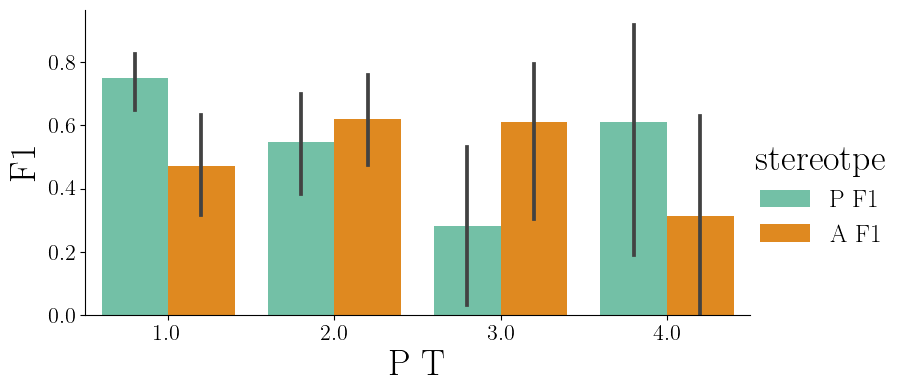

In [55]:
graph_5_delta_s("../data/de_results.txt", tokens_dict_de,"German", male_stereotype)

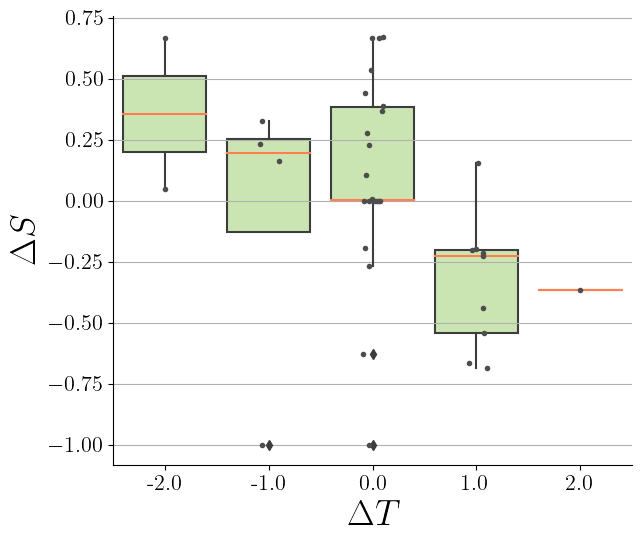

correlation
            $\Delta T$  $\Delta S$      P F1      A F1       P T       A T
$\Delta T$    1.000000   -0.365170 -0.334510  0.172641  0.509667 -0.521736
$\Delta S$   -0.365170    1.000000  0.692809 -0.695265 -0.448032 -0.069183
P F1         -0.334510    0.692809  1.000000  0.036622 -0.419159 -0.072045
A F1          0.172641   -0.695265  0.036622  1.000000  0.203100  0.024066
P T           0.509667   -0.448032 -0.419159  0.203100  1.000000  0.468078
A T          -0.521736   -0.069183 -0.072045  0.024066  0.468078  1.000000
    P T stereotpe        F1
0   1.0      P F1  0.666667
1   1.0      P F1  0.869565
2   1.0      P F1  0.727273
3   1.0      P F1  0.785047
4   1.0      P F1  0.756757
..  ...       ...       ...
71  2.0      A F1  0.683761
72  2.0      A F1  0.701754
73  2.0      A F1  0.745455
74  2.0      A F1  0.685714
75  3.0      A F1  0.717949

[76 rows x 3 columns]


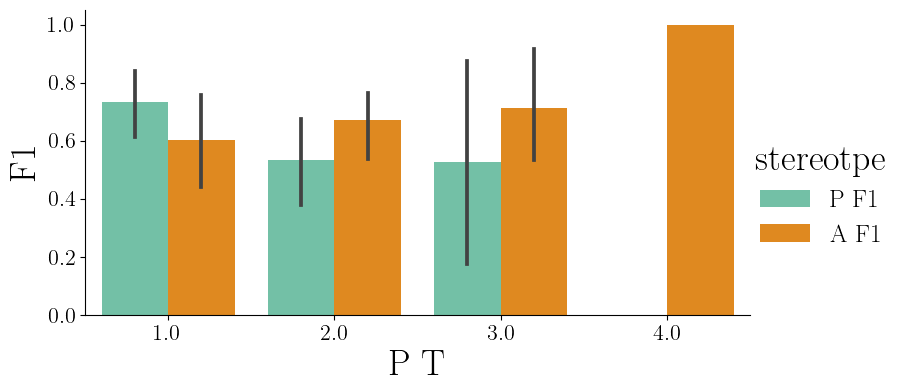

In [56]:
graph_5_delta_s("../data/es_results.txt", tokens_dict_es,"Spanish", male_stereotype)